In [1]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "04_detect_segment/04ab_retinanet_arthropods.ipynb" # change to reflect your notebook
_nb_title = "Object Detection with RetinaNet on Arthropods dataset / training" # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Object+Detection+with+RetinaNet+on+Arthropods+dataset+%2F+training&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F04_detect_segment%2F04ab_retinanet_arthropods.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/04_detect_segment/04ab_retinanet_arthropods.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/04_detect_segment/04ab_retinanet_arthropods.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/04_detect_segment/04ab_retinanet_arthropods.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# RetinaNetを使用した物体検出
このノートブックでは、Tensorflow Model GardenのRetinaNet実装を使用して、Arthropodデータセットの物体検出を行います。

## 実行環境
このノートブックは、TPUまたはGPUで実行するように設定されています。<br>
**GPUでは実行に時間がかかるため、特にTPUでの実行を推奨しています。**

Vertex AI WorkbenchやColabでTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

また、TPUでのトレーニングのために、書き込み可能なGCSバケットを使用する必要があります。以下のGCSバケットのセクションの手順に従ってセットアップを行ってください。

In [1]:
!pip install --quiet tf-models-official==2.8
# please restart the kernel after installs

In [ ]:
import os

IS_COLAB_BACKEND = 'COLAB_RELEASE_TAG' in os.environ  # this is always set on Colab
if IS_COLAB_BACKEND:
    
    # Get files
    BASE_PATH = "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/main/04_detect_segment"
    !wget {BASE_PATH}/utils_box.py

In [2]:
import time, re, os, math
import tensorflow as tf
import numpy as np
import pprint as pp
AUTO = tf.data.AUTOTUNE
print("Tensorflow version", tf.__version__)

from matplotlib import pyplot as plt
import matplotlib as mpl
import utils_box as box

# Tensorflow Model Garden imports
import official as model_garden
from official.vision.beta.configs import retinanet as retinanet_cfg
from official.vision.beta.configs import backbones as backbones_cfg
from official.vision.beta.serving import export_saved_model_lib
from official.core import train_lib

2022-12-10 18:25:43.875155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 18:25:43.875214: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.8.2


## Google Cloud Storageバケット
Colab環境の場合、Google Cloud Storageを利用するために認証を行う必要があります。以下を実行してアカウントを認証してください。

In [3]:
# If you are running on Colaboratory, you must authenticate
# for Colab to have write access to the bucket.

if IS_COLAB_BACKEND:
    from google.colab import auth
    auth.authenticate_user()

GCSバケットには以下を保存します。
 - 学習状況をモニタリングできるTensorboard用データ
 - モデルのCheckpointファイル
 - トレーニング後のSaved Modelファイル

以下の`BUCKET`の値を使用可能なGSCバケット名に変更して進めてください。

また、使用できるバケットがない場合は、以下の二行目と三行目のコマンドをコメントアウトし、`PROJECT`にGoogle Cloudプロジェク名を指定し、`gsutil mb`コマンドを実行して作成してください。<br>
（TPUでなくGPUを利用している場合は、GCSバケット使わずに`MODEL_ARTIFACT_BUCKET`にローカルパスを指定してもかまいません。）

In [ ]:
BUCKET='BUCKET_NAME' # Specify your GCS bucket name
# PROJECT = 'PROJECT_NAME'
# !gsutil mb -l us-central1 -p {PROJECT} gs://{BUCKET} 

In [6]:
MODEL_ARTIFACT_BUCKET = f'gs://{BUCKET}/arthropod_jobs/'
MODEL_DIR = MODEL_ARTIFACT_BUCKET + str(int(time.time()))

また、Colabから実行する際は、以下を実行してColabのTPU用サービスアカウントからのアクセスを許可してください。<br>
（ColabのTPUのサービスアカウントには以下の値が使用されていますが、もし後ほどアクセスエラーが出る場合は、以下の`COLAB_TPU_SERVICE_ACCOUNT`をエラーメッセージに出る`service-<Some Numbers>@cloud-tpu.iam.gserviceaccount.com` に置き換えて次のセルを再実行してください。

In [ ]:
if IS_COLAB_BACKEND:
    COLAB_TPU_SERVICE_ACCOUNT = "service-495559152420@cloud-tpu.iam.gserviceaccount.com"

    !gsutil iam ch serviceAccount:{COLAB_TPU_SERVICE_ACCOUNT}:objectAdmin gs://{BUCKET}
    !gsutil iam ch serviceAccount:{COLAB_TPU_SERVICE_ACCOUNT}:admin gs://{BUCKET}

## TPU/GPU検出

In [8]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-12-10 18:26:47.064521: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-10 18:26:47.064578: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:36347}
2022-12-10 18:26:47.068152: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-10 18:26:47.068191: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:36347}
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## チェックポイントファイルのダウンロード
事前学習済みのバックボーンの重みを使用するために、公式のレポジトリからチェックポイントファイルをダウンロードします。<br>
モデル毎のチェックポイントファイルは、[Githubのドキュメント](https://github.com/tensorflow/models/tree/master/official/vision)を参照してください。

ここでは、`Mobile SpineNet-49`をバックボーンとして利用します。

In [10]:
!gsutil cp gs://tf_model_garden/vision/retinanet/spinenet49mobile.tar.gz .
!tar xvzf ./spinenet49mobile.tar.gz
!gsutil cp ./ckpt-* gs://{BUCKET}/ckpt

Copying gs://tf_model_garden/vision/retinanet/spinenet49mobile.tar.gz...
/ [1 files][ 16.8 MiB/ 16.8 MiB]                                                
Operation completed over 1 objects/16.8 MiB.                                     
ckpt-277200.data-00000-of-00001
ckpt-277200.index
Copying file://./ckpt-277200.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./ckpt-277200.index [Content-Type=application/octet-stream]...   
/ [2 files][ 18.2 MiB/ 18.2 MiB]                                                
Operation completed over 2 objects/18.2 MiB.                                     


In [ ]:
!gsutil ls gs://{BUCKET}/ckpt

## 各種パラメータの設定

In [12]:
TRAIN_DATA_PATH_PATTERN = 'gs://practical-ml-vision-book/arthropod_detection_tfr/size_w1024px/*.train.tfrec'
VALID_DATA_PATH_PATTERN = 'gs://practical-ml-vision-book/arthropod_detection_tfr/size_w1024px/*.test.tfrec'

SPINET_MOBILE_CHECKPOINT = f'gs://{BUCKET}/ckpt/ckpt-277200'

BATCH_SIZE = 32 * strategy.num_replicas_in_sync

EPOCHS = 80

RAW_CLASSES = ['Lepidoptera', 'Hymenoptera', 'Hemiptera', 'Odonata', 'Diptera', 'Araneae', 'Coleoptera',
               '_truncated', '_blurred', '_occluded', ]
CLASSES = [klass for klass in RAW_CLASSES if klass not in ['_truncated', '_blurred', '_occluded']]

## データファイルのロード
データセットはすでにTFRecord形式で準備されています。<br/>
データの準備に使用したスクリプトは「04aa_retinanet_arthropods_dataprep.ipynb」を参照してください。<br/>

In [13]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return int(np.sum(n))

TRAIN_FILENAMES = tf.io.gfile.glob(TRAIN_DATA_PATH_PATTERN)
NB_TRAIN_IMAGES = count_data_items(TRAIN_FILENAMES)
STEPS_PER_EPOCH = NB_TRAIN_IMAGES // BATCH_SIZE

VALID_FILENAMES = tf.io.gfile.glob(VALID_DATA_PATH_PATTERN)
NB_VALID_IMAGES = count_data_items(VALID_FILENAMES)
VALID_STEPS = NB_VALID_IMAGES // BATCH_SIZE

print("Training dataset:")
print(f"    {len(TRAIN_FILENAMES)} TFRecord files.")
print(f"    {NB_TRAIN_IMAGES} images")
print("    Steps per epoch:", STEPS_PER_EPOCH)
print()
print("Validation dataset:")
print(f"    {len(VALID_FILENAMES)} TFRecord files.")
print(f"    {NB_VALID_IMAGES} images")
print("    Validation steps:", VALID_STEPS)
print()
print("Global batch size:", BATCH_SIZE)

Training dataset:
    24 TFRecord files.
    11544 images
    Steps per epoch: 45

Validation dataset:
    8 TFRecord files.
    3832 images
    Validation steps: 14

Global batch size: 256


## モデルの設定
Model Gardenでは、configファイルを使ってモデルの設定を行います。<br>
まず、reginanetのconfigのテンプレートを指定します。

テンプレートの一覧は[こちらのドキュメント](https://www.tensorflow.org/api_docs/python/tfm/core/exp_factory/get_exp_config)を参照してください。

In [25]:
params = model_garden.core.exp_factory.get_exp_config('retinanet')
pp.pprint(params.as_dict())

ダウンロードしたテンプレートを元にいくつかのパラメータを変更します。

まずは、データセット特有のクラス数やインプットサイズ、また、バックボーンの選択やチェックポイントファイルの指定を行いましょう。

In [28]:
IMAGE_SIZE = [384, 384]

params.task.model.num_classes = len(CLASSES)+1 # class 0 is reserved for backgrounds
params.task.model.input_size = [*IMAGE_SIZE, 3] # this automatically configures the input reader to random crop training images
params.task.init_checkpoint = SPINET_MOBILE_CHECKPOINT
params.task.init_checkpoint_modules = 'backbone'
params.task.model.backbone = backbones_cfg.Backbone(type='spinenet_mobile', spinenet_mobile=backbones_cfg.SpineNetMobile())

また、TPUを利用する場合はTPUについてのパラメータも変更します。

In [33]:
if type(strategy) == tf.distribute.TPUStrategy:
    params.runtime.distribution_strategy = 'tpu'
    params.runtime.tpu = tpu.get_master()

続いて、学習と評価、またオプティマイザについてのパラメータを上書きします。<br>
Model Gardenでは、定義済みのクラスを利用してパラメータを定義することも可能です。

ここでは、[retinanet用のconfigsクラス](https://www.tensorflow.org/api_docs/python/tfm/vision/configs/retinanet)を利用します。


In [ ]:
train_data_cfg=retinanet_cfg.DataConfig(
    input_path=TRAIN_DATA_PATH_PATTERN,
    is_training=True,
    global_batch_size=BATCH_SIZE,
    parser=retinanet_cfg.Parser(aug_rand_hflip=True, aug_scale_min=0.7, aug_scale_max=2.0))

valid_data_cfg=retinanet_cfg.DataConfig(
    input_path=VALID_DATA_PATH_PATTERN,
    is_training=False,
    global_batch_size=BATCH_SIZE)

params.override({'task': {'train_data': train_data_cfg.as_dict(), 'validation_data': valid_data_cfg.as_dict()}})

trainer_cfg=model_garden.core.config_definitions.TrainerConfig(
    train_steps=EPOCHS * STEPS_PER_EPOCH,
    validation_steps=VALID_STEPS,
    validation_interval=8*STEPS_PER_EPOCH,
    steps_per_loop=STEPS_PER_EPOCH,
    summary_interval=STEPS_PER_EPOCH,
    checkpoint_interval=8*STEPS_PER_EPOCH)

optim_cfg = model_garden.modeling.optimization.OptimizationConfig({
    'optimizer': {
                  'type': 'sgd',
                  'sgd': {'momentum': 0.9}},
    'learning_rate': {'type': 'stepwise',
                      'stepwise': {'boundaries': [15 * STEPS_PER_EPOCH,
                                                  30 * STEPS_PER_EPOCH,
                                                  45 * STEPS_PER_EPOCH,
                                                  60 * STEPS_PER_EPOCH,
                                                  75 * STEPS_PER_EPOCH],
                                   'values': [0.016, #0.01,
                                              0.008, #0.005,
                                              0.004, #0.0025,
                                              0.002, #0.001,
                                              0.001, #0.0005,
                                              0.0005]} #0.00025]}
                     },
    #'warmup': {'type': 'linear','linear': {'warmup_steps': 5*STEPS_PER_EPOCH, 'warmup_learning_rate': 0.00001}}
})

trainer_cfg.override({'optimizer_config': optim_cfg})
params.override({'trainer': trainer_cfg})

pp.pprint(params.as_dict())

## モデルの作成

In [35]:
task = model_garden.core.task_factory.get_task(params.task, logging_dir=MODEL_DIR)

## モデルの学習
モデルの学習を行います。学習には、TPUv3-8で約30分、ColabのTPUv2-8で40分かかります。

In [36]:
print(MODEL_DIR)
model,_ = train_lib.run_experiment(
    distribution_strategy=strategy,
    task=task,
    mode="train", # 'train', 'eval', 'train_and_eval' or 'continuous_eval'
    params=params,
    model_dir=MODEL_DIR)

gs://takumi-od-test-2/arthropod_jobs/1670696796
restoring or initializing model...
initialized model.
train | step:      0 | training until step 3600...
train | step:     45 | steps/sec:    0.1 | output: 
    {'box_loss': 0.008960684,
     'cls_loss': 0.9140627,
     'learning_rate': 0.016,
     'model_loss': 1.3620965,
     'total_loss': 1.3620965,
     'training_loss': 1.3620965}
saved checkpoint to gs://takumi-od-test-2/arthropod_jobs/1670696796/ckpt-45.
train | step:     90 | steps/sec:    1.5 | output: 
    {'box_loss': 0.0051912772,
     'cls_loss': 0.63583314,
     'learning_rate': 0.016,
     'model_loss': 0.8953971,
     'total_loss': 0.8953971,
     'training_loss': 0.8953971}
train | step:    135 | steps/sec:    2.5 | output: 
    {'box_loss': 0.0043003415,
     'cls_loss': 0.5700023,
     'learning_rate': 0.016,
     'model_loss': 0.78501946,
     'total_loss': 0.78501946,
     'training_loss': 0.78501946}
train | step:    180 | steps/sec:    2.4 | output: 
    {'box_loss':

## モデルのエクスポート

In [38]:
export_saved_model_lib.export_inference_graph(
      input_type='image_tensor',
      batch_size=4,
      input_image_size=IMAGE_SIZE,
      params=params,
      checkpoint_path=MODEL_DIR,
      export_dir=MODEL_DIR,
      export_checkpoint_subdir='saved_chkpt',
      export_saved_model_subdir='saved_model')

2022-12-10 19:26:15.714140: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://takumi-od-test-2/arthropod_jobs/1670696796/saved_model/assets


INFO:tensorflow:Assets written to: gs://takumi-od-test-2/arthropod_jobs/1670696796/saved_model/assets


モデルは以下のパスにエクスポートされました。

In [ ]:
print(f'saved model path: {MODEL_DIR}/saved_model')

## 推論の準備
モデルの学習、モデルのエクスポートが完了しました。続けて、推論のための準備を行いましょう。

### TFRecordsからのデータローダーの定義

In [41]:
def read_tfrecord(example):
    feature = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string), # compressed image bytes
        "image/source_id": tf.io.FixedLenFeature([], tf.string),  # string
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
        "image/object/class/label": tf.io.VarLenFeature(tf.int64) # one tag per box
    }
    example = tf.io.parse_single_example(example, feature)
    source_id = example['image/source_id']
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    boxes_xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    boxes_xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    boxes_ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    boxes_ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    boxes = tf.stack([boxes_xmin, boxes_ymin, boxes_xmax, boxes_ymax], axis=-1)
    labels = tf.sparse.to_dense(example['image/object/class/label'])
    return image, source_id, boxes, labels
    
def load_tfrecord_dataset(filenames):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

## 推論用の前処理の定義

In [50]:
TARGET_SIZE = [384,384]

# Returns two crop_boxes. The first is the preferred crop box,
# the second one is an alternative.
# output format: x1 y1 x2 y2 in relative image coordinates
def compute_crop_boxes(image_size, target_aspect_ratio):
    W = image_size[1]
    w = target_aspect_ratio[1]
    H = image_size[0]
    h = target_aspect_ratio[0]
    # box with desired aspect ration that fits in the image horizontally
    crop_box1 = [0.0, (1-W/w*h/H)/2.0, 1.0, (1+W/w*h/H)/2.0] # format x1 y1 x2 y2
    # box with desired aspect ration that fits in the image vertically
    crop_box2 = [(1-w/W*H/h)/2.0, 0.0, (1+w/W*H/h)/2.0, 1.0] # format x1 y1 x2 y2
    # select the box that crops the image, not the one that adds black borders
    return tf.cond(crop_box1[1]>0, lambda:(crop_box1, crop_box2), lambda:(crop_box2, crop_box1))

# Resize images to TARGET_SIZE. Crop if necessary and if cropping does not cut any
# bounding boxes. Pad otherwise. This must be run without batching.
def resize_and_crop_image_and_boxes(im, source_id, boxes, labels):
    image_size = tf.cast(tf.shape(im)[0:2], tf.float32)
    # boxes back to image coordinates
    boxes = box.scale_rois(boxes, image_size)
    crop_boxes = compute_crop_boxes(image_size, TARGET_SIZE)
    
    # select the cropping method so as not to lose any bounding box
    tiles = box.scale_rois(crop_boxes, image_size) # convert to absolute image coordinates
    _, is_roi_in_tile = box.find_fully_intersecting_rois(tiles, boxes) # [n_tiles, n_rois]
    crop_box = tf.cond(tf.reduce_all(is_roi_in_tile[0]), lambda: crop_boxes[0], lambda:crop_boxes[1])
    
    # resize image
    crop_box_for_tfimage = box.swap_xy(crop_box) # tf.image.crop_and_resize expects y1 x1 y2 x2 coordinates
    crop_box_for_tfimage = tf.expand_dims(crop_box_for_tfimage, axis=0) # tf.image.crop_and_resize expects a list of boxes
    box_indices = tf.zeros([1], tf.int32) # all boxes refer to the same image
    images = tf.expand_dims(im, axis=0) # tf.image.crop_and_resize expects a batch of images
    images = tf.image.crop_and_resize(images, crop_box_for_tfimage, box_indices, [TARGET_SIZE[1], TARGET_SIZE[0]])
    im = tf.cast(tf.squeeze(images, axis=0), tf.uint8)
    
    # resize boxes
    tiles = box.scale_rois(crop_box, image_size) # convert to absolute image coordinates
    tiles = tf.expand_dims(tiles, axis=0) # box.rois_in_tiles_relative expects a list of tiles (we have one)
    boxes, is_box_in_tile = box.rois_in_tiles_relative(tiles, boxes)
    boxes = tf.squeeze(boxes, axis=0) # we have only one crop tile
    boxes = box.scale_rois(boxes, tf.cast(TARGET_SIZE, tf.float32))
    #boxes = tf.cast(tf.round(boxes), tf.int32)
    
    # assert fail when losing boxes dues to cropping (not implemented)
    assert_op = tf.debugging.assert_equal(tf.reduce_all(is_box_in_tile), True, message=
        "Cropping causes boxes to fall outside of the image. The code for properly "
        "removing these boxes and their associated classes is not written so you cannot do that.")
    with tf.control_dependencies([assert_op]):
         boxes = tf.identity(boxes)
    
    return im, source_id, boxes, labels



In [51]:
DATA_PATH_PATTERN = 'gs://practical-ml-vision-book/arthropod_detection_tfr/size_w1024px/*test.tfrec'

filenames = tf.io.gfile.glob(DATA_PATH_PATTERN)
dataset = load_tfrecord_dataset(filenames)
dataset = dataset.map(resize_and_crop_image_and_boxes)
dataset = dataset.shuffle(100)
dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(4))
dataset_iterator = iter(dataset)

## 可視化ユーティリティ

In [52]:
def no_decorations(ax):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
# images, boxes and classes must have the same number of elements
# scores can be en empty list []. If it is not empty, it must also
# have the same number of elements.
# classnames is the list of possible classes (strings)
def display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes=[]):
    N = len(images)
    sqrtN = int(math.ceil(math.sqrt(N)))
    aspect = sum([im.shape[1]/im.shape[0] for im in images])/len(images) # mean aspect ratio of images
    fig = plt.figure(figsize=(15,15/aspect), frameon=False)
    
    for k in range(N):
        ax = plt.subplot(sqrtN, sqrtN, k+1)
        no_decorations(ax)
        plt.imshow(images[k])
        
        if ground_truth_boxes:
            for box in ground_truth_boxes[k]:
                x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
                #x, y, w, h = (box[0], box[1], box[2], box[3])
                rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#FFFFFFA0',facecolor='none')
                ax.add_patch(rect)

        for i, (box, klass) in enumerate(zip(boxes[k], classes[k])):
            x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
            #x, y, w, h = (box[0], box[1], box[2], box[3])
            #label = classnames[klass-1] # predicted classes are 1-based
            label = classnames[klass]
            if scores:
                label += ' ' + str(int(scores[k][i]*100)) + '%' 
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#00000080',facecolor='none')
            ax.add_patch(rect)
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=2,edgecolor='#FFFF00FF',facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#00000080', fc='#0000004E', linewidth=3) )
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#FFFF00FF', fc='#0000004E', linewidth=1.5) )
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

## サンプル画像の確認
グラウンドトゥルースボックスのサイズが適切に変更されたことを確認します

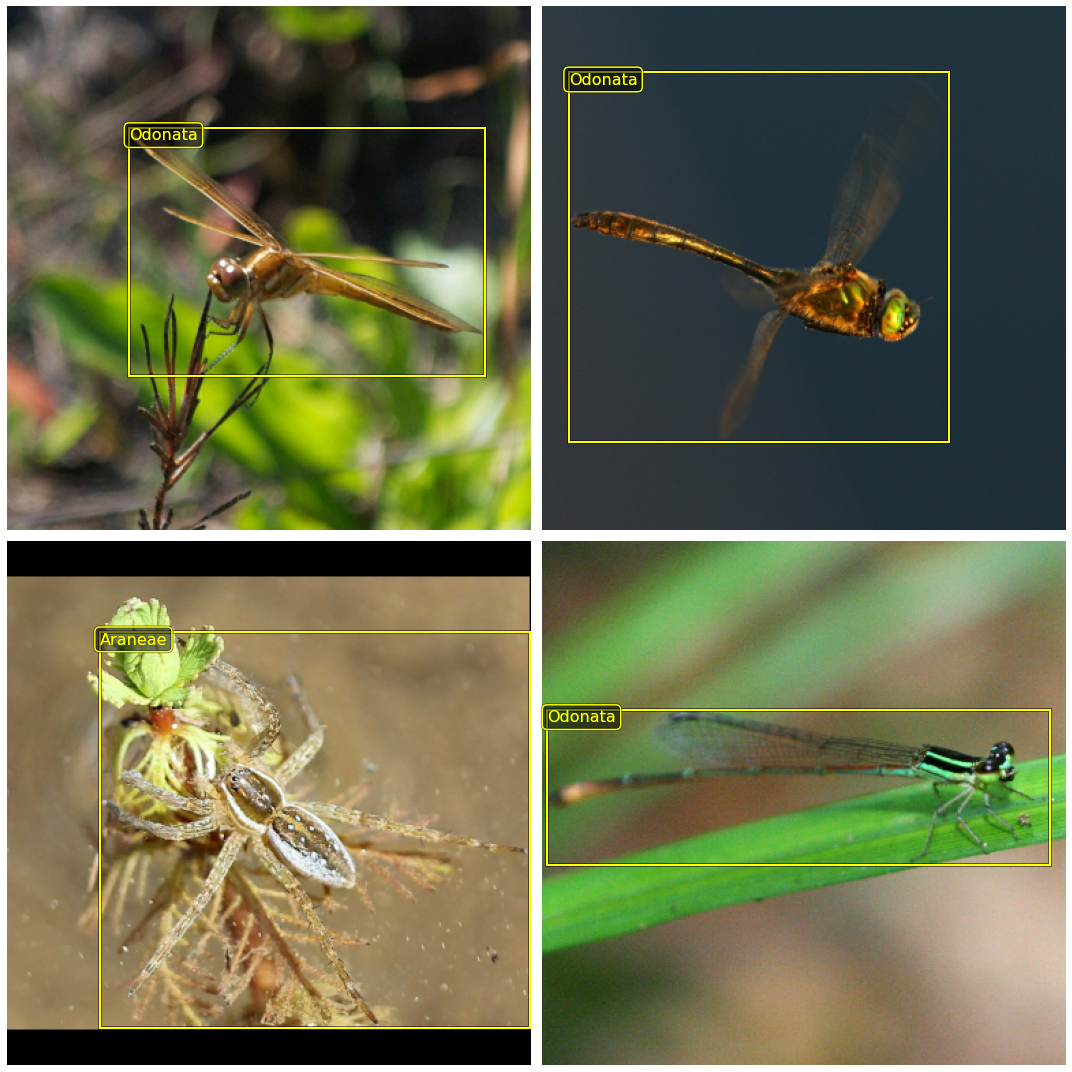

In [53]:
# you can run this entire section multiple times to load and predict on new images

# sample images
image_tensor, source_ids, ground_truth_boxes, labels = next(dataset_iterator)
images = [im.numpy() for im in image_tensor] # must do this for ragged

# must shift labels back to 0-based for visualization
labels -= 1 
display_with_boxes(images, ground_truth_boxes, labels, None, CLASSES, ground_truth_boxes=[])

## 学習済みのモデルをロード

In [ ]:
restored_model = tf.saved_model.load(f"{MODEL_DIR}/saved_model")

## 推論の実行

In [55]:
# runnig the model
detections = restored_model.signatures['serving_default'](inputs=image_tensor)

SCORE_TRESHOLD = 0.3
all_boxes=[]
all_classes=[]
all_scores=[]
all_gtboxes=[]
for i, (boxes, classes, scores, _) in enumerate(zip(detections['detection_boxes'],
                                                    detections['detection_classes'],
                                                    detections['detection_scores'],
                                                    detections['num_detections'])):
    
    # reversing order because the model tends to return the most probable detections last, while I want them displayed on top
    # swapping x,y in boxes because the Model Garden standard is y,x while the display code uses x,y
    
    boxes2 = [box.swap_xy(bbox) for i,bbox in reversed(list(enumerate(boxes))) if scores[i]>SCORE_TRESHOLD]
    classes2 = [lbl-1 for i,lbl in reversed(list(enumerate(classes.numpy()))) if scores[i]>SCORE_TRESHOLD]
    scores2 = [scr for scr in reversed(scores.numpy()) if scr>SCORE_TRESHOLD]
    gt_boxes2 = [gtbox.numpy() for gtbox in ground_truth_boxes[i]] # must do this for ragged
    all_boxes.append(boxes2)
    all_classes.append(classes2)
    all_scores.append(scores2)
    all_gtboxes.append(gt_boxes2)

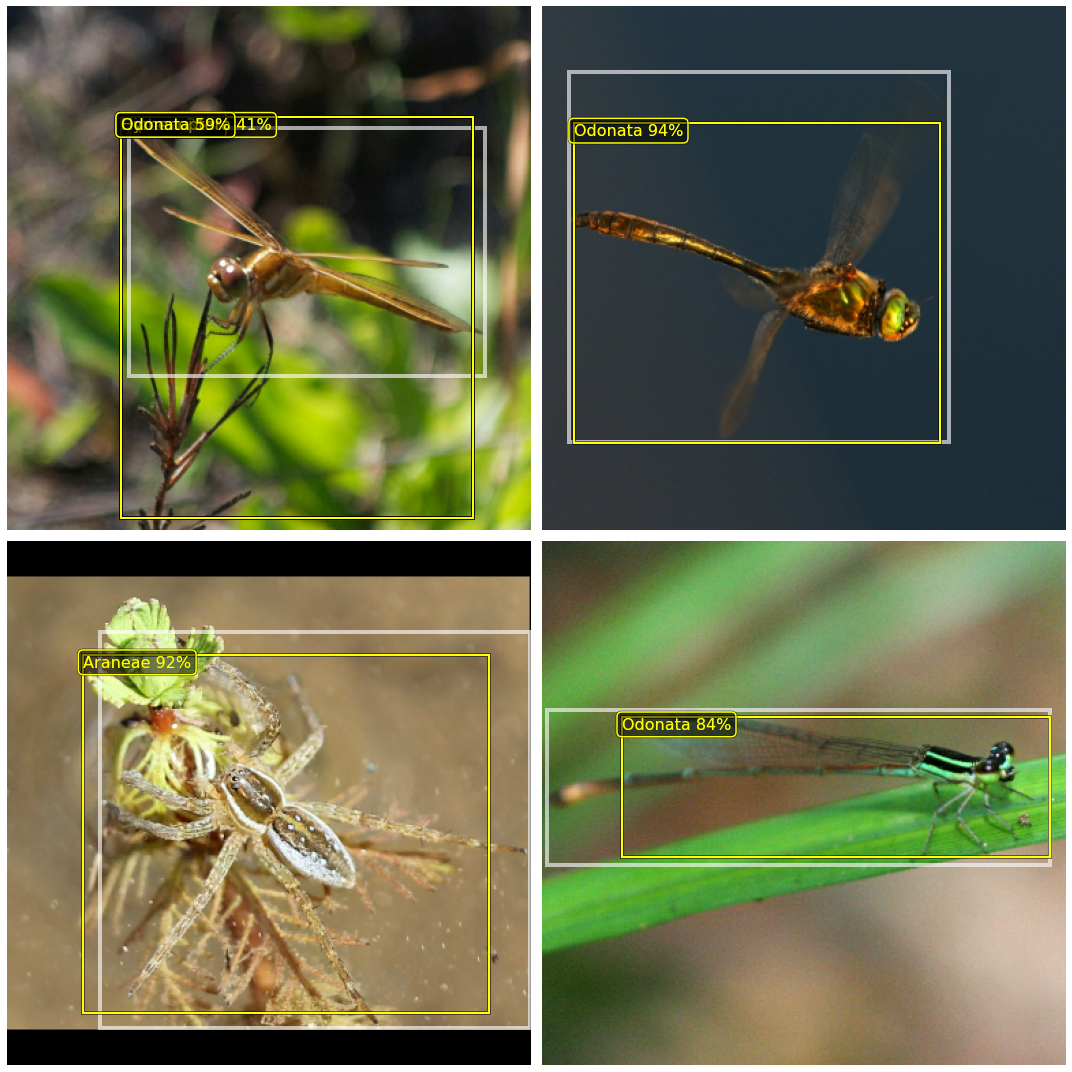

In [56]:
# display results (detection boxes in yellow, ground truth boxes in grey)
display_with_boxes(image_tensor, all_boxes, all_classes, all_scores, CLASSES, ground_truth_boxes=all_gtboxes)

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.